# Logistic Regression

The focus of this week is implementing the Laplace approximation to the logistic regression problem described in lectures.

## Overview
- **Task 1**: Calculate the Laplace Approximation to the posterior distribution
- **Task 2**: Sample from the Laplace Approximation to plot decision boundaries
- **Epilogue**: Use automatic differentiation (autodiff) to calculate the gradient and Hessian.


In [1]:
# Necessary packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle
import scipy.optimize

# %matplotlib notebook
%matplotlib inline

## Load in the required data

Load the data saved in the file `observed_data.p` (e.g., using `pickle`). It contains your observation in the form of `X` values and `y` binary labels as type `np.array`.

In [2]:
##### Your code goes here #####
data = np.load('./observed_data.p', allow_pickle=True)
X_data = data['X']
y_data = data['y']

In [3]:
X_data.shape, y_data.shape

((100, 2), (100,))

## Visualize the data

Let us plot the data in the two classes  to see if we can separate the classes visually.

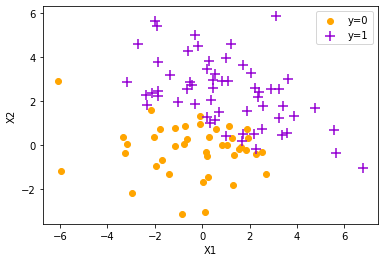

In [4]:
# plot data
fig,ax = plt.subplots()
ax.scatter(X_data[y_data==0,0], X_data[y_data==0,1], color='orange', label='y=0')
ax.scatter(X_data[y_data==1,0], X_data[y_data==1,1], color='darkviolet', marker="+" ,s=100,label='y=1') 
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.legend()

plt.show()

## Add dummy X variable

We might want to learn an offset as well for the decision boundary, instead of just $w_1x + w_2y$. Modify `X_data` so that the first row is filled by 1's. 

In [5]:
X = np.c_[np.ones((X_data.shape[0], 1)), X_data]
y = y_data

In [6]:
X.shape

(100, 3)

## Task 1 - Define Logistic Regression Model

Recall from the lectures the likelihood model for logistic regression with weights $w$.

\begin{equation}
p(y|w,x) = \left\{
    \begin{split}
    \sigma(x^\top w) \quad & y=1\\
    1-\sigma(x^\top w) \quad & y=0
    \end{split}
     \right.
\end{equation}

Where $\sigma$ is the sigmoid function
\begin{equation}
\sigma(z) = \frac{1}{1+\exp(-z)}
\end{equation}

Recall that assuming that the different datapoints $(x,y)$ are independent, then $p(Y|w,X) = \prod_{i=1}^{N}p(y_i|w.x_i)$.

Implement the functions below.

In [7]:
w = np.array([0.1, 0.1, 0.1])
np.matmul(X, w).shape, y

((100,),
 array([0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0,
        1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
        1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1]))

In [8]:
y

array([0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1])

In [9]:
def sigmoid(z):
    # your code here...
    # raise NotImplementedError
    return 1/(1+np.exp(-z))  # caution: do not do `z=z-z.max()` as it is sigmoid, not softmax!
    

def log_likelihood(w, X, y):
    # your code here...
    # raise NotImplementedError
    z = np.matmul(X, w)  # [100, 3] x[3, 1]
    y_ = np.zeros_like(y); y_[y==1]=1; y_[y==0]=-1  # relabel to 1,-1
    return np.log(sigmoid(y_*z)).sum()

In [10]:
z = np.matmul(X, w)
y_ = np.zeros_like(y); y_[y==1]=1; y_[y==0]=-1

np.log(sigmoid(y_*z)).sum()
log_likelihood(w, X, y), np.log(sigmoid(z[y==1])).sum() + np.log(1. - sigmoid(z[y==0])).sum()

(-59.121976082980254, -59.121976082980254)

In [11]:
np.log(  sigmoid(np.matmul(X, w)[y==1])  ).sum() + np.log( 1 - sigmoid(np.matmul(X, w)[y==0])  ).sum()

-59.121976082980254

## Finding the Laplace Approximation

Now, let us move on to the task of approximating a posterior distribution. Assumke we define a Gaussian prior over the weights:
\begin{equation}
p(w) = \mathcal{N}(w; 0, \sigma^{2}_{w}I)
\end{equation}

Then recall that the Laplace approximation is given by $p(w|Y,X) \approx \mathcal{N}(w; w_{*}, -\mathcal{H}^{-1})$, and is found in two steps:
- **Step 1**: Calculate the mode $w_{*}$ of $\log p(w|Y,X)$ by gradient ascent.
- **Step 2**: Compute the Hessian matrix at the mode:
\begin{equation}
\mathcal{H} = \nabla\nabla \log p(w|Y,X)|_w{*}
\end{equation}

Implement the functions below to calculate the negative log posterior

In [14]:
# w.T
Sigma_inv = 1/(prior_sigma**2) * np.eye(len(w))
w1 = w.reshape(-1, 1)
np.dot(w, Sigma_inv@w)

0.030000000000000006

In [15]:
# Compute Laplace Approximation
prior_sigma = 1.0



def log_prior(w):
    # your code here...
    # raise NotImplementedError
    Sigma_inv = 1/(prior_sigma**2) * np.eye(len(w))
    return -0.5*np.dot(w, Sigma_inv@w)  # caution: do not miss the 0.5!!!!

def neg_log_posterior(w, X, y):
    # your code here...
    # raise NotImplementedError
    return -(log_prior(w) + log_likelihood(w, X, y))

We minimize the negative log posterior to find the MAP

In [16]:
w = np.array([0.1, 0.1, 0.1])

laplace_opt=scipy.optimize.minimize(neg_log_posterior,  # objective function f(w, *args)
                                    w,
                                    args=(X,y), # other arguments to objective
                                    jac=False,  # Method for computing the gradient vector.
                                    options={'maxiter':25}
                                   )
map = laplace_opt.x
print(map)

[-1.93153227  0.81397871  2.1046409 ]


### Visualize the results

Let's plot the predictions using the MAP (choosing the class that is most likely, even if the predicted probability is close to 0.5). Let's also plot whether this prediction matches the true label or not to see how we did.

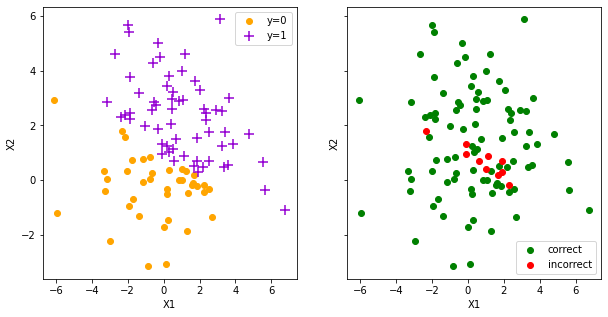

In [17]:
# MAP predictions

y_pred = np.round(sigmoid(X.dot(map)))
fig,ax = plt.subplots(figsize=(10,5),ncols=2,sharey=True)
ax[0].scatter(X_data[y_pred==0,0], X_data[y_pred==0,1], color='orange', label='y=0')
ax[0].scatter(X_data[y_pred==1,0], X_data[y_pred==1,1], color='darkviolet', marker="+" ,s=100,label='y=1')
ax[0].set_xlabel('X1')
ax[0].set_ylabel('X2')
ax[0].legend()
ax[1].scatter(X_data[y_data==y_pred,0], X_data[y_data==y_pred,1], color='green', label='correct')
ax[1].scatter(X_data[y_data!=y_pred,0], X_data[y_data!=y_pred,1], color='red', label='incorrect')
ax[1].set_xlabel('X1')
ax[1].set_ylabel('X2')
ax[1].legend()


## Implement the Hessian matrix

Complete the function below and evaluate the matrix at the MAP calculated above.

In [18]:
z = np.matmul(X, w)
# sigmoid(1-z)

In [19]:
# np.diag(np.exp(np.matmul(X, map)))

In [20]:
def hessian(w, X, y):
    # your code here...
    # raise NotImplementedError
    z=np.matmul(X, w)
    R=np.diag(sigmoid(z)*(1-sigmoid(z)))  # caution: it is not sigmoid(1-z)!!!!
    return -X.T@R@X  - (1/prior_sigma**2)*np.eye(len(w))


H = hessian(map, X, y)

post_mean = map
post_cov = np.linalg.inv(-H)

print(f'Posterior mean: {post_mean}')
print(f'Posterior covariance: {post_cov}')

Posterior mean: [-1.93153227  0.81397871  2.1046409 ]
Posterior covariance: [[ 0.22434649 -0.05484873 -0.14074999]
 [-0.05484873  0.03913767  0.05163597]
 [-0.14074999  0.05163597  0.1622508 ]]


In [21]:
H

array([[-10.225489  ,  -4.52863092,  -7.42922178],
       [ -4.52863092, -46.04950109,  10.72663853],
       [ -7.42922178,  10.72663853, -16.02175852]])

## Task 2 - Sample from Posterior and visualize the results

One way to visualize the posterior is to plot the decision boundaries associated with samples from the posterior.

The predicted probability of both classes will be exactly 0.5 when $\sigma(x^{\top}w) = 0.5$, which holds when $x^{\top}w= 0$. Recalling that we introduced a dummy variable at the beginning of this notebook, we expand the above product as $w_0 + w_1x_1 + w_2x_2 =0$.

Therefore, for every sample from the posterior $w\sim p(w|Y,X)$, we can plot the corresponding decision boundary by plotting the line $x_2 = \frac{-w_0 - w_1x_1}{w_2}$. We can also color each decision boundary proportional to the posterior probability of $w$.

Implement the missing code blocks below to generate the decision boundary plots.


In [23]:
# post_prob(w, post_mean, post_cov)

/var/folders/qp/4w02sqhj6_d43815lhzjb7900000gn/T/ipykernel_42767/270863172.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('winter')


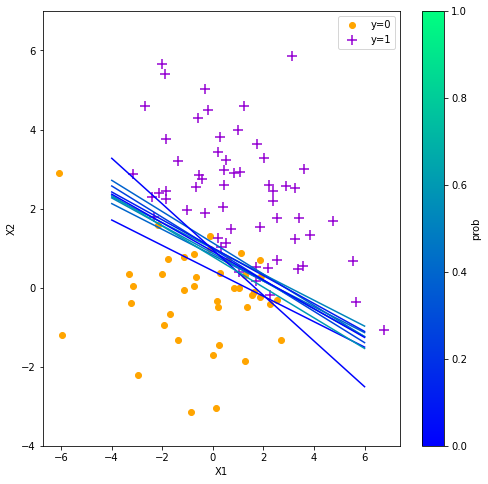

In [24]:
cmap = mpl.cm.get_cmap('winter')

def draw_posterior_sample(mean,cov):
    # This function should return one sample from the posterior distribution
    # Hint: use np.random.multivariate_normal
    # your code here...
    return np.random.multivariate_normal(mean=mean, cov=cov, size=(1,))[0]
    
def post_prob(w, mean, cov):
    # This function should return the probability of the sample w under the posterior distribution
    # your code here...
    import scipy
    mvn = scipy.stats.multivariate_normal(mean=mean, cov=cov)
    return mvn.pdf(w)

# normalzing values to [0,1] for color mapping
# What is the maximum probability of the posterior distribution?
# (Hint: max value is achieved at the MAP).
w_prob_max = post_prob(post_mean, post_mean, post_cov)#your code here...



fig,ax = plt.subplots(figsize=(8,8))
x1 = np.linspace(-4,6,100) #fixed array of first coordinate x values to plot lines with
for i in range(10):
    w_post = draw_posterior_sample(post_mean, post_cov)
    w_prob = post_prob(w_post,post_mean,post_cov)
    x2 = (-w_post[0]-w_post[1]*x1)/w_post[2]   # Calculate the x2 values for the decision boundary
    ax.plot(x1,x2,c = cmap(w_prob/w_prob_max)) # Plot the line and color it according to the probability of w

# Plot the dataset as before
ax.scatter(X_data[y_data==0,0], X_data[y_data==0,1], color='orange', label='y=0',zorder=-1)
ax.scatter(X_data[y_data==1,0], X_data[y_data==1,1], color='darkviolet', marker="+", s=100,
           label='y=1', zorder=-1) 
ax.set_xlabel('X1'); ax.set_ylabel('X2'); ax.legend(); ax.set_ylim(-4,7)
fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=1), cmap=cmap),
             ax=ax, label='prob');

## Epilogue - Automatic Differentiation

In this exercise, we calculated analytic expressions for the Hessian matrix (and did not explicitly used the analytic derivative to solve the optimization problem to find the the MAP, although this would have made the task even easier). 

Sometimes, analytic expressions are not possible to obtain. However, using automatic differentiation, we can compute derivatives when we calculate the value of the log-posterior, without providing analytical expressions!

Here, we will reimplement the functions from Task 1, but now using an automatic differentiation framework, and show how we can calculate the derivative (and the Hessian) of the log-posterior. 

We will use [Pytorch](https://pytorch.org/get-started/locally/) for this demonstration, so make sure you have a local installation. There are other automatic differentiation libraries in python, namely [JAX](https://jax.readthedocs.io/en/latest/installation.html).

In [25]:
# Required imports
import torch
import torch.optim as optim

In [26]:
X_torch = torch.Tensor(X) #Convert X to a torch tensor
y_torch = torch.Tensor(y) #Convert y to a torch tensor

### Reimplemeting the log-posterior

The functions should be the same as the functions defined at the start of this notebook, but all functions should now be in `torch` - you should not use any numpy functions or arrays here.

In [27]:
# You don't need to re-implement sigmoid, as you can use torch.sigmoid()!


def torch_log_likelihood(w, X, y):
    # your code here...
    z = torch.matmul(X, w)  # [100, 3] x[3, 1]
    y_ = torch.zeros_like(y); y_[y==1]=1; y_[y==0]=-1  # relabel to 1,-1
    return torch.log(torch.sigmoid(y_*z)).sum()

def torch_log_prior(w):
    # your code here...
    Sigma_inv = 1/(prior_sigma**2) * torch.eye(len(w))
    return -0.5*torch.dot(w, Sigma_inv@w)

def torch_neg_log_posterior(w, X, y):
    #your code here...
    return -(torch_log_prior(w) + torch_log_likelihood(w, X, y))

In [28]:
w_torch = torch.Tensor(w)
torch_log_likelihood(w_torch, X_torch, y_torch)

tensor(-59.1220)

### Calculating the MAP

We can now get the gradient of the log posterior using automatic differentiation! Let's use it to write our own simple optimization loop (as opposed to the previous optimization using `scipy`).

In [29]:
map_torch = torch.tensor([0.1, 0.1, 0.1], requires_grad=True) #Initialize w as a torch tensor
optimizer = optim.SGD([map_torch],lr=0.01) #Initialize a basic pytorch optimizer

for i in range(200):
    optimizer.zero_grad() #make sure we do not carry any gradients from the previous iteration
    loss = torch_neg_log_posterior(map_torch, X_torch, y_torch) #Compute the negative log posterior
    loss.backward() #Compute the gradient of the negative log posterior
    optimizer.step() #Update the weights
    if i%10 == 0:
        print("negative log posterior: " ,loss.item())

# Compare the MAP estimates from the two methods
print("MAP computed with autoamtic differentiation: " , map_torch.data)
print("MAP computed with scipy: " , map)

negative log posterior:  59.13697814941406
negative log posterior:  29.034833908081055
negative log posterior:  26.221303939819336
negative log posterior:  25.215778350830078
negative log posterior:  24.78070831298828
negative log posterior:  24.573545455932617
negative log posterior:  24.46928596496582
negative log posterior:  24.414953231811523
negative log posterior:  24.385982513427734
negative log posterior:  24.37027931213379
negative log posterior:  24.361675262451172
negative log posterior:  24.356922149658203
negative log posterior:  24.354280471801758
negative log posterior:  24.35280990600586
negative log posterior:  24.35198402404785
negative log posterior:  24.351520538330078
negative log posterior:  24.35126304626465
negative log posterior:  24.351112365722656
negative log posterior:  24.351032257080078
negative log posterior:  24.350984573364258
MAP computed with autoamtic differentiation:  tensor([-1.9278,  0.8128,  2.1016])
MAP computed with scipy:  [-1.93153227  0.813

### Calculating the Hessian

Similarly, we can compute the Hessian when computing the log-posterior using automatic differentiation.

In [30]:
# Negative hessian as we calculated the negative log posterior
neg_hessian = torch.autograd.functional.hessian(torch_neg_log_posterior, (map_torch, X_torch,y_torch), create_graph=True)
# We actually get the hessian for all inputs, (so also for X and y!). We only care about the Hessian for the weights.
H_torch = -neg_hessian[0][0]

# Compare the Hessian with the one you computed before
print("Analytical Hessian:")
print(H)
print("PyTorch Hessian:")
print(H_torch.detach().numpy())

Analytical Hessian:
[[-10.225489    -4.52863092  -7.42922178]
 [ -4.52863092 -46.04950109  10.72663853]
 [ -7.42922178  10.72663853 -16.02175852]]
PyTorch Hessian:
[[-10.234274   -4.5320725  -7.4355993]
 [ -4.532073  -46.092392   10.732538 ]
 [ -7.4355993  10.732539  -16.041096 ]]
